# Deconvolve
### Dependencies

In [1]:
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from heracles.catalog import FitsCatalog

## Data

In [15]:
nside = 1024
lmax = 1000

# load the FITS catalogue
wlfs2_cat = FitsCatalog('/home/jaimerz/Documents/UCL/heracles/data/wlfs2_dr1n_vis24.5_nomag.fits')

# Load visibility map
vmap = hp.read_map('/home/jaimerz/Documents/UCL/heracles/data/vmap_wlfs2_dr1n_vis24.5_nomag.fits')
vmap[vmap == hp.UNSEEN] = 0.
vmap = hp.ud_grade(vmap, 2*nside)
# set visibility map of entire catalogue
wlfs2_cat.visibility = vmap

0.0 180.0 -180.0 180.0


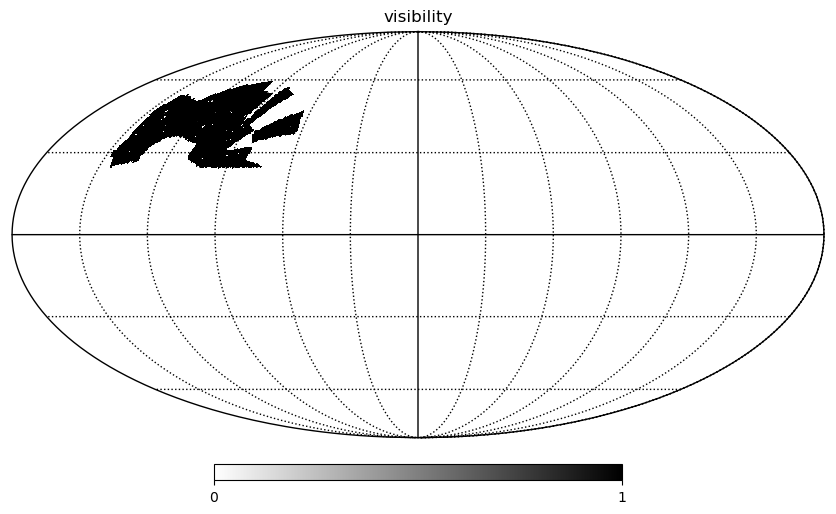

In [14]:
hp.mollview(vmap, title='visibility', cmap='binary', bgcolor='none')
hp.graticule()
plt.show()

### Tomographic binning

In [8]:
catalogs = {0: wlfs2_cat['TOM_BIN_ID == 0']}

### Fields

In [16]:
from heracles.fields import Positions, Shears
from heracles.maps import Healpix

mapper = Healpix(nside, lmax)

fields = {
    "P": Positions(mapper, "RIGHT_ASCENSION", "DECLINATION", mask="V"),
    "G": Shears(mapper, "RIGHT_ASCENSION", "DECLINATION", "G1", "-G2", "WEIGHT", mask="W"),
}

### Maps

In [24]:
from heracles.maps import map_catalogs

data = map_catalogs(fields, catalogs, parallel=True, progress=True)

Output()

[('P', 0), ('G', 0)]

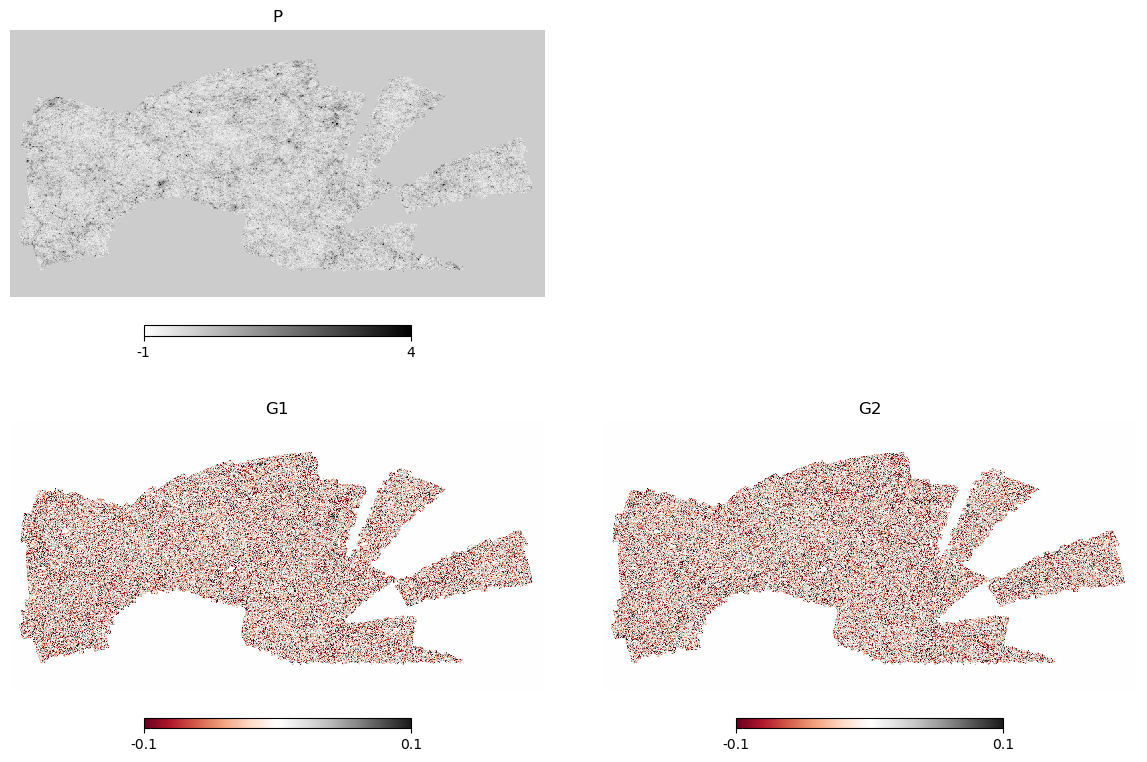

In [26]:
i = 0

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout()
plt.sca(ax[0, 0])
hp.cartview(data['P', i], title='P', cmap='binary', min=-1., max=4., hold=True,
            lonra=[60, 150], latra=[20, 65])
ax[0, 1].axis('off')
plt.sca(ax[1, 0])
hp.cartview(data['G', i][0], title='G1', cmap='RdGy', min=-0.1, max=0.1, hold=True,
            lonra=[60, 150], latra=[20, 65])
plt.sca(ax[1, 1])
hp.cartview(data['G', i][1], title='G2', cmap='RdGy', min=-0.1, max=0.1, hold=True,
            lonra=[60, 150], latra=[20, 65])
plt.show()

### Alms

In [30]:
from heracles.maps import transform
alms = transform(fields, data, progress=True)
list(alms.keys())

Output()

[('P', 0), ('G', 0)]

### Two-point statistics

In [31]:
from heracles.twopoint import angular_power_spectra, bin2pt
cls = angular_power_spectra(alms)
list(cls.keys())

[('P', 'P', 0, 0),
 ('P', 'G_E', 0, 0),
 ('P', 'G_B', 0, 0),
 ('G_E', 'G_E', 0, 0),
 ('G_E', 'G_B', 0, 0),
 ('G_B', 'G_B', 0, 0)]

### Binning

In [32]:
bin_edges = np.linspace(0, lmax, 31).astype(int)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
binned_ls = B['L']
B = B['B']

n, m = B.shape
B2 = np.zeros((n, 2*lmax+1))
B2[:, :lmax+1] = B

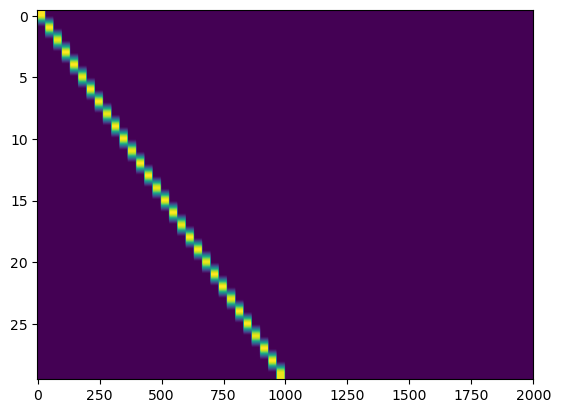

In [33]:
plt.imshow(B2, aspect='auto')

### Mixing matrices

In [36]:
from heracles.fields import Visibility, Weights
from heracles.twopoint import mixing_matrices
from heracles.maps import map_catalogs

In [37]:
mapper_mm = Healpix(2*nside, 2*lmax)
# visibility maps are taken as-is from catalogue, so no columns
fields_mm = {
    "V": Visibility(mapper_mm),
    "W": Weights(mapper_mm, "RIGHT_ASCENSION", "DECLINATION", "WEIGHT"),
}

data_mm = map_catalogs(fields_mm, catalogs, parallel=True, progress=True)

Output()

Fourrier transform the mask and compute its angular power spectra

In [ ]:
alms_mm = transform_maps(fields_mm, maps_mm, progress=True)
cls_mm = angular_power_spectra(alms_mm)

Compute the mixing matrix given the masks and the fields

In [ ]:
mms = mixing_matrices(fields, cls_mm, l1max=lmax, l2max=lmax, progress=True)
mms

In [ ]:
plt.imshow(mms[('P', 'P', 0, 0)], cmap='binary',
            norm=mpl.colors.LogNorm(vmin=1e-7))
plt.colorbar(pad=0.025, fraction=0.0465)
plt.show()

In [ ]:
np.shape(cls[('P', 'P', 0, 0)])

In [ ]:
np.shape(mms[('P', 'P', 0, 0)])

In [ ]:
from heracles.core import TocDict

deconvolved_cls = TocDict()
deconvolved_cls[('P', 'P', 0, 0)] = cls[('P', 'P', 0, 0)] @ np.transpose(np.linalg.pinv(mms[('P', 'P', 0, 0)]))
deconvolved_cls

In [ ]:
plt.plot(cls[('P', 'P', 0, 0)], label="Cls")
plt.plot(cls[('P', 'P', 0, 0)] @ mms[('P', 'P', 0, 0)], label="Cls * M")
plt.plot(cls[('P', 'P', 0, 0)] @ np.transpose(mms[('P', 'P', 0, 0)]), label="Cls * M^{T}")
plt.plot(cls[('P', 'P', 0, 0)] @ np.linalg.pinv(mms[('P', 'P', 0, 0)]),
         label="Cls * M^{-1}")
plt.plot(cls[('P', 'P', 0, 0)] @ np.transpose(np.linalg.pinv(mms[('P', 'P', 0, 0)])),
         label="Cls * M^{-1, T}")
plt.loglog()
plt.legend()
plt.show()

### Theory

In [ ]:
import camb
from camb.sources import SplinedSourceWindow

In [ ]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False 
pars.NonLinear = camb.model.NonLinear_both
pars.set_for_lmax(lmax, lens_potential_accuracy=1);

Load in nz's

In [ ]:
nz = fitsio.read('/pscratch/sd/j/jaimerz/Data/reduced_flagship2/nz_wlfs2_dr1n_vis24.5_mag.fits')

In [ ]:
z = nz['Z_MID']
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3

In [ ]:
sources = []
for i in range(len(catalogs)):
    nz_i = nz[f'BIN{i}']
    sources += [SplinedSourceWindow(source_type='counts', z=z, W=nz_i, bias_z=bz)]
pars.SourceWindows = sources

In [ ]:
results = camb.get_results(pars)
theory_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)
theory_cls

In [ ]:
plt.plot(theory_cls['PxP'], '--', label="PxP")
plt.plot(theory_cls['PxW1'], '-', label="PxW1")
plt.plot(theory_cls['W1xP'], '--', label="W1xP")
plt.plot(theory_cls['W1xW1'], '--', label="W1xW1")
plt.legend()
plt.loglog()
plt.show()

In [ ]:
theory_pcls = TocDict()
theory_pcls[('P', 'P', 0, 0)] =  mms['P', 'P', 0, 0] @ theory_cls['W1xW1']
theory_pcls

### Comparison

In [ ]:
plt.plot(cls[('P', 'P', 0, 0)], label="Measured Cls")
plt.plot(deconvolved_cls[('P', 'P', 0, 0)], label="Deconvolved Cls")

plt.plot(theory_cls['W1xW1'], '--', label="Theory Cls")
plt.plot(theory_pcls[('P', 'P', 0, 0)], '--', label="Theory pseudo-Cls")

plt.loglog()
plt.legend()
plt.show()